## Module 3. I will construct Machine Learning and Deep Learning models to model the impact of Donald Trump's tweets on odds price changes of S&P

For this purposes I will construct RNN model more specifically LSTM model as a deep learning model for predicting effect on S&P price increase using just text of tweet. This approach is very naive and disregards all other indicators that affect price as we want just to see the impact scale of tweets.

In addition we will also create Logistic Regression model as typical algorithm in Machine Learning to get coefficients or simply what are top words which have biggest impact. So Deep Learning model provides us with predictive power whereas Machine Learning algorithm with interpretation.

# Importing neccessary libraries

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, re, gc
import sys, time
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout, SimpleRNN, LSTM, CuDNNLSTM, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

In [2]:
# parse_dates is neccessary for python to identify that the varible will indicate time, while encoding type should be changed to
# unicode escape as the default 'utf-8' cannot decode the unrecognizable symbols 

df_tweet=pd.read_csv('Trump.csv', parse_dates=['Date'],encoding = 'unicode_escape')
df_tweet.tail(2)

,source,text,Date,retweet_count,favorite_count,is_retweet,id_str
3063,Twitter for Android,@jallenaip: Hillary said she was in a Fog of W...,2016-01-01,2721,7490,False,6.830000e+17
3064,Twitter for Android,Do you believe that The State Department on NE...,2015-12-31,2755,6824,False,6.830000e+17


In [3]:
df_stock=pd.read_csv('stock.csv', parse_dates=['Date'])
df_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-30,2077.340088,2077.340088,2061.969971,2063.360107,2063.360107,2367430000
1,2015-12-31,2060.590088,2062.540039,2043.619995,2043.939941,2043.939941,2655330000
2,2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4304880000
3,2016-01-05,2013.780029,2021.939941,2004.170044,2016.709961,2016.709961,3706620000
4,2016-01-06,2011.709961,2011.709961,1979.050049,1990.260010,1990.260010,4336660000


In [4]:
df_stock['Change']=df_stock['Close'].pct_change()
df_stock['Difference'] = df_stock['Close'].diff()
df_stock.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,Change,Difference
0,2015-12-30,2077.340088,2077.340088,2061.969971,2063.360107,2063.360107,2367430000,NaN,NaN
1,2015-12-31,2060.590088,2062.540039,2043.619995,2043.939941,2043.939941,2655330000,-0.009412,-19.420166


In [5]:
df_stock=df_stock.dropna()
df_stock.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,Change,Difference
1,2015-12-31,2060.590088,2062.540039,2043.619995,2043.939941,2043.939941,2655330000,-0.009412,-19.420166
2,2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4304880000,-0.015304,-31.279907


In [6]:
df=pd.merge(df_tweet, df_stock, on='Date', how='left')

In [7]:
df['Change_bin'] = 0
df.loc[(df['Change'] > 0), 'Change_bin'] = 1
df.head(2)

,source,text,Date,retweet_count,favorite_count,is_retweet,id_str,Open,High,Low,Close,Adj Close,Volume,Change,Difference,Change_bin
0,Twitter for iPhone,RT @WhiteHouse: ? 13000 new construction jobs?...,2019-10-11,4555,0,True,1.180000e+18,2963.070068,2993.280029,2963.070068,2970.27002,2970.27002,3.580460e+09,0.010939,32.140137,1
1,Twitter for iPhone,RT @WhiteHouse: USMCA updates NAFTA to achieve...,2019-10-11,3294,0,True,1.180000e+18,2963.070068,2993.280029,2963.070068,2970.27002,2970.27002,3.580460e+09,0.010939,32.140137,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3065 entries, 0 to 3064
Data columns (total 16 columns):
source            3065 non-null object
text              3061 non-null object
Date              3065 non-null datetime64[ns]
retweet_count     3065 non-null int64
favorite_count    3065 non-null object
is_retweet        3047 non-null object
id_str            3065 non-null float64
Open              2155 non-null float64
High              2155 non-null float64
Low               2155 non-null float64
Close             2155 non-null float64
Adj Close         2155 non-null float64
Volume            2155 non-null float64
Change            2155 non-null float64
Difference        2155 non-null float64
Change_bin        3065 non-null int64
dtypes: datetime64[ns](1), float64(9), int64(2), object(4)
memory usage: 407.1+ KB


In [9]:
df= df[~df['favorite_count'].isin(['FALSE', 'TRUE'])]

In [10]:
df.drop('is_retweet', axis=1, inplace=True)
df = df.dropna().reset_index(drop=True)
df.head(2)

,source,text,Date,retweet_count,favorite_count,id_str,Open,High,Low,Close,Adj Close,Volume,Change,Difference,Change_bin
0,Twitter for iPhone,RT @WhiteHouse: ? 13000 new construction jobs?...,2019-10-11,4555,0,1.180000e+18,2963.070068,2993.280029,2963.070068,2970.27002,2970.27002,3.580460e+09,0.010939,32.140137,1
1,Twitter for iPhone,RT @WhiteHouse: USMCA updates NAFTA to achieve...,2019-10-11,3294,0,1.180000e+18,2963.070068,2993.280029,2963.070068,2970.27002,2970.27002,3.580460e+09,0.010939,32.140137,1


In [11]:
df

,source,text,Date,retweet_count,favorite_count,id_str,Open,High,Low,Close,Adj Close,Volume,Change,Difference,Change_bin
0,Twitter for iPhone,RT @WhiteHouse: ? 13000 new construction jobs?...,2019-10-11,4555,0,1.180000e+18,2963.070068,2993.280029,2963.070068,2970.270020,2970.270020,3.580460e+09,0.010939,32.140137,1
1,Twitter for iPhone,RT @WhiteHouse: USMCA updates NAFTA to achieve...,2019-10-11,3294,0,1.180000e+18,2963.070068,2993.280029,2963.070068,2970.270020,2970.270020,3.580460e+09,0.010939,32.140137,1
2,Twitter for iPhone,RT @WaysandMeansGOP: #USMCA will build on the ...,2019-10-11,2835,0,1.180000e+18,2963.070068,2993.280029,2963.070068,2970.270020,2970.270020,3.580460e+09,0.010939,32.140137,1
3,Twitter for iPhone,RT @WhiteHouse: ? Median household income is a...,2019-10-11,5099,0,1.180000e+18,2963.070068,2993.280029,2963.070068,2970.270020,2970.270020,3.580460e+09,0.010939,32.140137,1
4,Twitter for iPhone,RT @MariaBartiromo: USMCA passage China deal s...,2019-10-11,2569,0,1.180000e+18,2963.070068,2993.280029,2963.070068,2970.270020,2970.270020,3.580460e+09,0.010939,32.140137,1
5,Twitter for iPhone,One of the great things about the China Deal i...,2019-10-11,12241,53363,1.180000e+18,2963.070068,2993.280029,2963.070068,2970.270020,2970.270020,3.580460e+09,0.010939,32.140137,1
6,Twitter for iPhone,I will be in Louisiana tonight (Love it!) to g...,2019-10-11,10472,39299,1.180000e+18,2963.070068,2993.280029,2963.070068,2970.270020,2970.270020,3.580460e+09,0.010939,32.140137,1
7,Twitter for iPhone,Good things are happening at China Trade Talk ...,2019-10-11,13838,64494,1.180000e+18,2963.070068,2993.280029,2963.070068,2970.270020,2970.270020,3.580460e+09,0.010939,32.140137,1
8,Twitter for iPhone,Big day of negotiations with China. They want ...,2019-10-10,18884,96365,1.180000e+18,2918.550049,2948.459961,2917.120117,2938.129883,2938.129883,3.217250e+09,0.006416,18.729981,1
9,Twitter for iPhone,...Court Justice &amp; I turned him down (hes...,2019-10-10,17441,73067,1.180000e+18,2918.550049,2948.459961,2917.120117,2938.129883,2938.129883,3.217250e+09,0.006416,18.729981,1


###  The two classes of the binary variables are almost equal which indicates that the data is balanced, which is a good news for the modeling.

In [12]:
df.Change_bin.value_counts()

1    1190
0     961
Name: Change_bin, dtype: int64

In [13]:
X=df.text
y=df.Change_bin

### Splitting into training testing sets

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)

### Text tokenization

Common step before using text for modeling is tokenization and preprocessing which will be done using keras model function in deep learning section.

The reason why we do tokenication is very simple. As you can imagine without tokenization rows contain a sentence , in this specific case tweet, which is just plain text. But we know that such models need numbers to work with.Thus, with tokenization there are several steps we transform text into numbers. We take all unique words in all rows and then make another big table with all unique values in tweets as columns. Then we run each tweet and put 1 in column with word, which is present in that tweet. And we are doing this row by row. At the end we will have a matrix or table with m by n size, where m is number of tweets and n is number of unique words in all tweets. 

In [213]:
tokenizer = Tokenizer()

In [19]:
start_time = time.time()

tokenizer.fit_on_texts(X)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.38430118560791016 seconds ---


In [20]:
word_index = tokenizer.word_index

In [21]:
len(word_index)

6801

In [141]:
start_time = time.time()

sequences_train = tokenizer.texts_to_matrix(X_train, mode='count')

print("--- %s seconds ---" % (time.time() - start_time))

--- 1.4895193576812744 seconds ---


In [142]:
start_time = time.time()

sequences_test = tokenizer.texts_to_matrix(X_test, mode='count')

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.42706847190856934 seconds ---


# CuDNNLSTM with embedding layer

In this jupyter notebook we are using CuDNNLSTM which is a member of LSTM family models. For execution time reduction CuDNNLSTM is great as it makes calculations using GPU which significantly decreases execution time.

In this first model we will incorporate Embedding layer thus we are making sparse matrix of words into lower dimensional dense matrix.

In [41]:
# define the model
model = Sequential()
model.add(Embedding(5000, 128, input_length=len(word_index)+1))
model.add(CuDNNLSTM(128,return_sequences=True))
model.add(CuDNNLSTM(64,return_sequences=True))
model.add(CuDNNLSTM(32))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 6802, 128)         640000    
_________________________________________________________________
cu_dnnlstm_9 (CuDNNLSTM)     (None, 6802, 128)         132096    
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 6802, 64)          49664     
_________________________________________________________________
cu_dnnlstm_11 (CuDNNLSTM)    (None, 32)                12544     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 834,337
Trainable params: 834,337
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
start_time = time.time()

hist = model.fit(sequences_train, y_train, epochs=5, verbose=True, validation_data=(sequences_test, y_test))
# evaluate the model
model.evaluate(sequences_test, y_test, verbose=True)

print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\Gaya\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1720 samples, validate on 431 samples
Epoch 1/5
1720/1720 [==============================] - 781s 454ms/step - loss: 0.6896 - acc: 0.5535 - val_loss: 0.6877 - val_acc: 0.5522
Epoch 2/5
1720/1720 [==============================] - 1006s 585ms/step - loss: 0.6889 - acc: 0.5535 - val_loss: 0.6877 - val_acc: 0.5522
Epoch 3/5
1720/1720 [==============================] - 818s 476ms/step - loss: 0.6887 - acc: 0.5535 - val_loss: 0.6877 - val_acc: 0.5522
Epoch 4/5
1720/1720 [==============================] - 1032s 600ms/step - loss: 0.6887 - acc: 0.5535 - val_loss: 0.6877 - val_acc: 0.5522
Epoch 5/5
431/431 [==============================] - 120s 278ms/step
--- 5061.5862147808075 seconds ---


We train on train set and validate on test set. As it can be seen, the accuracy has not changed throughout training process, indicated that the model is not satisfactory  in addition its long execution time. Next we will construct LSTM model without Embedding layer which sometimes is very useful especially when you have great number of uniqie words, which is not true, as in our case with nearly 7k vocabulary or unique words.

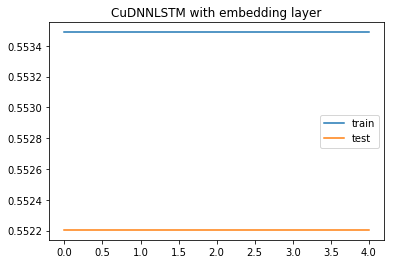

In [44]:
plt.title('Accuracy')
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='test')
plt.title('CuDNNLSTM with embedding layer')
plt.legend()
plt.show();

In [48]:
model.save('my_model_lstm_emb.h5')  # creates a HDF5 file 'my_model.h5'

# CuDNNLSTM without embedding layer

Next we will try without Embedding layer and you will se the results

In [143]:
sequences_train2 = sequences_train.reshape((sequences_train.shape[0],1,sequences_train.shape[1]))
sequences_test2 = sequences_test.reshape((sequences_test.shape[0],1,sequences_test.shape[1]))

Basically we are building LSTM model with 3 hidden layers (2 layers with 128 units and then one layer of 64 units). At end we have our output layer with sigmoid activation as we have 2 target classes (increase/ decrease S&P price)

FOr avoiding overfitting, I use SGD optimizer and tweet parameters accordingly.Shortly, it can be seen that this is real problem with the small dataset we have. We also apply strong regularization using Dropout layers and l2 regularizers which shrink coefficients and don't allow model to choose specific words and assign big weights to them.

In [91]:
# define the model
model2 = Sequential()
model2.add(CuDNNLSTM(128,input_shape=(sequences_train2.shape[1],sequences_train2.shape[2]),return_sequences=True, kernel_regularizer=regularizers.l2(0.000001), bias_regularizer=regularizers.l2(0.000001)))
model2.add(Dropout(0.3))
model2.add(CuDNNLSTM(128,return_sequences=True, kernel_regularizer=regularizers.l2(0.000001), bias_regularizer=regularizers.l2(0.0001)))
model2.add(Dropout(0.3))
model2.add(CuDNNLSTM(64, kernel_regularizer=regularizers.l2(0.0000001), bias_regularizer=regularizers.l2(0.0000001)))
model2.add(Dense(1, activation='sigmoid'))
# compile the model
sgd = tf.keras.optimizers.SGD(lr=0.08, decay=1e-4, momentum=1, nesterov=False)
model2.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_57 (CuDNNLSTM)    (None, 1, 128)            3549184   
_________________________________________________________________
dropout_38 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
cu_dnnlstm_58 (CuDNNLSTM)    (None, 1, 128)            132096    
_________________________________________________________________
dropout_39 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
cu_dnnlstm_59 (CuDNNLSTM)    (None, 64)                49664     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 3,731,009
Trainable params: 3,731,009
Non-trainable params: 0
_________________________________________________________________


In [92]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model_lstm.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

For generalization purposes we also set early stopping callback and model checkpoint to save best model during the training

In [93]:
start_time = time.time()

hist2 = model2.fit(sequences_train2, y_train, epochs=100, verbose=True, validation_data=(sequences_test2, y_test), callbacks=[es, mc], batch_size=128)
# evaluate the model
model2.evaluate(sequences_test2, y_test, verbose=True)

print("--- %s seconds ---" % (time.time() - start_time))

Train on 1720 samples, validate on 431 samples
Epoch 1/100
1720/1720 [==============================] - 17s 10ms/step - loss: 0.7059 - acc: 0.5471 - val_loss: 0.7060 - val_acc: 0.5522
Epoch 2/100
1720/1720 [==============================] - 2s 1ms/step - loss: 0.7072 - acc: 0.5535 - val_loss: 0.7017 - val_acc: 0.5522
Epoch 3/100
1720/1720 [==============================] - 2s 1ms/step - loss: 0.7052 - acc: 0.5105 - val_loss: 0.7067 - val_acc: 0.5522
Epoch 4/100
1720/1720 [==============================] - 2s 1ms/step - loss: 0.7030 - acc: 0.5535 - val_loss: 0.7065 - val_acc: 0.5522
Epoch 5/100
1720/1720 [==============================] - 2s 1ms/step - loss: 0.7047 - acc: 0.5535 - val_loss: 0.7010 - val_acc: 0.5522
Epoch 6/100
1720/1720 [==============================] - 2s 1ms/step - loss: 0.7023 - acc: 0.5535 - val_loss: 0.7022 - val_acc: 0.5522
Epoch 7/100
1720/1720 [==============================] - 2s 1ms/step - loss: 0.7001 - acc: 0.5535 - val_loss: 0.7021 - val_acc: 0.5522
Epoch 

Execution time is faster without Embedding layer as well as the accuracy and loss metrics.

In graph below you see that during first 30 epochs training and testing losses were moving together but somewhere at 28-29th epochs they moved into different directions, so to prevent overfitting early callback stopped the further training. 

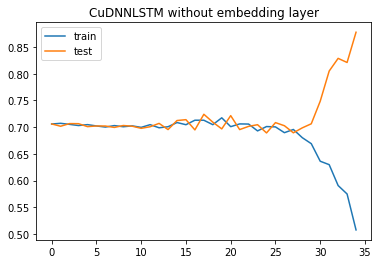

In [94]:
plt.title('Accuracy')
plt.plot(hist2.history['loss'], label='train')
plt.plot(hist2.history['val_loss'], label='test')
plt.title('CuDNNLSTM without embedding layer')
plt.legend()
plt.show();

Again we see that we stopped at right moement when overfitting started.

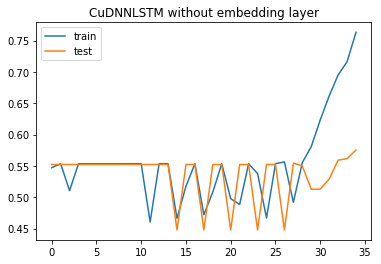

In [95]:
plt.title('Accuracy')
plt.plot(hist2.history['acc'], label='train')
plt.plot(hist2.history['val_acc'], label='test')
plt.title('CuDNNLSTM without embedding layer')
plt.legend()
plt.show();

In [133]:
y_preds_lstm2=((model2.predict(sequences_test2)>0.5)*1).reshape(-1,)

### An imporatant point is that we see the overall accuracy on test set in 57%, which is not bad as we predict price changes in S&P 500 index correctly in more than half time cases. So theoretically we can use this model and have gain in long-term. It is also known that financial market is highly volatile so models which are slightly better than random choice are already good and in our case it is 7%  more precision than random choice.

In [134]:
accuracy_score(y_test,y_preds_lstm2)

0.5754060324825986

In [135]:
print(classification_report(y_test,y_preds_lstm2))

              precision    recall  f1-score   support

           0       0.59      0.17      0.26       193
           1       0.57      0.91      0.70       238

   micro avg       0.58      0.58      0.58       431
   macro avg       0.58      0.54      0.48       431
weighted avg       0.58      0.58      0.50       431



We see that we predict price decrease as price increase in 43% cases incorrectly but again we can gain in long term. It is also clear we have problems with predicting price decrease as out recal is just 17%.

In [132]:
print(confusion_matrix(y_test,y_preds_lstm2))

[[ 32 161]
 [ 22 216]]


In [136]:
model2.save('y_preds_lstm2.h5')  # creates a HDF5 file 'my_model.h5'

# Logistic Regression

So basically Deep Learning models are considered black box models cause we cannot interpret all those weight in simple way that is why we will also use Logistic Regression to model and interpret coefficients of the model.

In [148]:
vect = TfidfVectorizer(min_df=2, max_df=0.4, ngram_range=(1, 2), stop_words='english')

In [149]:
X_train_dtm = vect.fit_transform(X_train)

In [150]:
X_train=pd.DataFrame(X_train_dtm.toarray(), columns=vect.get_feature_names(),index=X_train.index)
X_train

,0cpnuzjqb9,10,10 million,100,100 billion,100 correct,11,11 2016,12,13,...,yesterday,yesterday today,york,york times,youth,zell,zero,zero day,zones,zte
2005,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
806,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1072,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1418,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
587,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1734,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
624,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1868,0.0,0.000000,0.0,0.359758,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
622,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
538,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [152]:
X_testdtm = vect.transform(X_test)

In [153]:
X_test=pd.DataFrame(X_testdtm.toarray(), columns=vect.get_feature_names(),index=X_test.index)
X_test

,0cpnuzjqb9,10,10 million,100,100 billion,100 correct,11,11 2016,12,13,...,yesterday,yesterday today,york,york times,youth,zell,zero,zero day,zones,zte
2143,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1252,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1342,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1105,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1927,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1269,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1829,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1471,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
log=LogisticRegression()
log.fit(X_train, y_train)

C:\Users\Gaya\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [155]:
log_preds=log.predict(X_test)

In [156]:
accuracy_score(y_test,log_preds)

0.5591647331786543

In [157]:
print(classification_report(y_test,log_preds))

              precision    recall  f1-score   support

           0       0.51      0.34      0.41       193
           1       0.58      0.74      0.65       238

   micro avg       0.56      0.56      0.56       431
   macro avg       0.55      0.54      0.53       431
weighted avg       0.55      0.56      0.54       431



In [158]:
confusion_matrix(y_test,log_preds)

array([[ 65, 128],
       [ 62, 176]], dtype=int64)

Below you can observe Coefficients by name and their value.

In [177]:
coefs_logreg = pd.DataFrame({'Coefficient': X_train.columns,'Value': log.coef_[0]}).sort_values('Value')
coefs_logreg

,Coefficient,Value
1297,disaster,-0.987693
4940,work,-0.948002
656,campaign,-0.922964
2415,japan,-0.835629
4003,saying,-0.817127
4870,way,-0.815024
529,bigleaguetruth,-0.783250
1908,going,-0.778463
1409,draintheswamp,-0.772841
4993,year,-0.770298


To make this coefficients values more interpretable we take exponent of them and that will show us the impact of this feauture on S&P price change. Thus, if exponent of value for feature is lower than 1 it means that word decreases odds of S&P 500 index price increase, and if it bigger than 1 word increases odds of S&P 500 index price increase.

In [178]:
coefs_logreg['exp_Value'] = np.exp(coefs_logreg ['Value'])

In [179]:
coefs_logreg['effect_on_odds_of_S&P'] = coefs_logreg['exp_Value'] - 1

S&P odds = (probability of S&P price increase)/(probability of S&P price decrease)

effect_on_odds_of_S column just represents change in odds with sign minus means odds are being decreased + means odds are increasing.

In [180]:
coefs_logreg

,Coefficient,Value,exp_Value,effect_on_odds_of_S&P
1297,disaster,-0.987693,0.372435,-0.627565
4940,work,-0.948002,0.387514,-0.612486
656,campaign,-0.922964,0.397340,-0.602660
2415,japan,-0.835629,0.433602,-0.566398
4003,saying,-0.817127,0.441699,-0.558301
4870,way,-0.815024,0.442629,-0.557371
529,bigleaguetruth,-0.783250,0.456918,-0.543082
1908,going,-0.778463,0.459111,-0.540889
1409,draintheswamp,-0.772841,0.461700,-0.538300
4993,year,-0.770298,0.462875,-0.537125


In [186]:
neg_top20 = coefs_logreg.head(20)
neg_top20

,Coefficient,Value,exp_Value,effect_on_odds_of_S&P
1297,disaster,-0.987693,0.372435,-0.627565
4940,work,-0.948002,0.387514,-0.612486
656,campaign,-0.922964,0.397340,-0.602660
2415,japan,-0.835629,0.433602,-0.566398
4003,saying,-0.817127,0.441699,-0.558301
4870,way,-0.815024,0.442629,-0.557371
529,bigleaguetruth,-0.783250,0.456918,-0.543082
1908,going,-0.778463,0.459111,-0.540889
1409,draintheswamp,-0.772841,0.461700,-0.538300
4993,year,-0.770298,0.462875,-0.537125


In [187]:
pos_top20 = coefs_logreg.tail(20)
pos_top20

,Coefficient,Value,exp_Value,effect_on_odds_of_S&P
4424,tax cuts,0.640264,1.896982,0.896982
809,clinton,0.641226,1.898807,0.898807
4387,talking,0.653748,1.922734,0.922734
2741,lot,0.668047,1.950425,0.950425
2717,looking forward,0.668985,1.952256,0.952256
3680,really,0.671905,1.957964,0.957964
4929,won,0.676276,1.966540,0.966540
3544,process,0.677924,1.969784,0.969784
2898,meeting,0.686494,1.986738,0.986738
3952,russian,0.691301,1.996311,0.996311


In [192]:
pd.concat([pos_top20, neg_top20])

,Coefficient,Value,exp_Value,effect_on_odds_of_S&P
4424,tax cuts,0.640264,1.896982,0.896982
809,clinton,0.641226,1.898807,0.898807
4387,talking,0.653748,1.922734,0.922734
2741,lot,0.668047,1.950425,0.950425
2717,looking forward,0.668985,1.952256,0.952256
3680,really,0.671905,1.957964,0.957964
4929,won,0.676276,1.966540,0.966540
3544,process,0.677924,1.969784,0.969784
2898,meeting,0.686494,1.986738,0.986738
3952,russian,0.691301,1.996311,0.996311


In [193]:
coefs = pd.concat([pos_top20, neg_top20]).Coefficient.tolist()
probs_logs_odds = pd.concat([pos_top20, neg_top20])['effect_on_odds_of_S&P'].tolist()
y_pos = np.arange(len(coefs))

In [196]:
y_pos

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

In graph below you can observe top 20 postive (in blue) and negative words (in red) that affect the odds of S&P price increase.

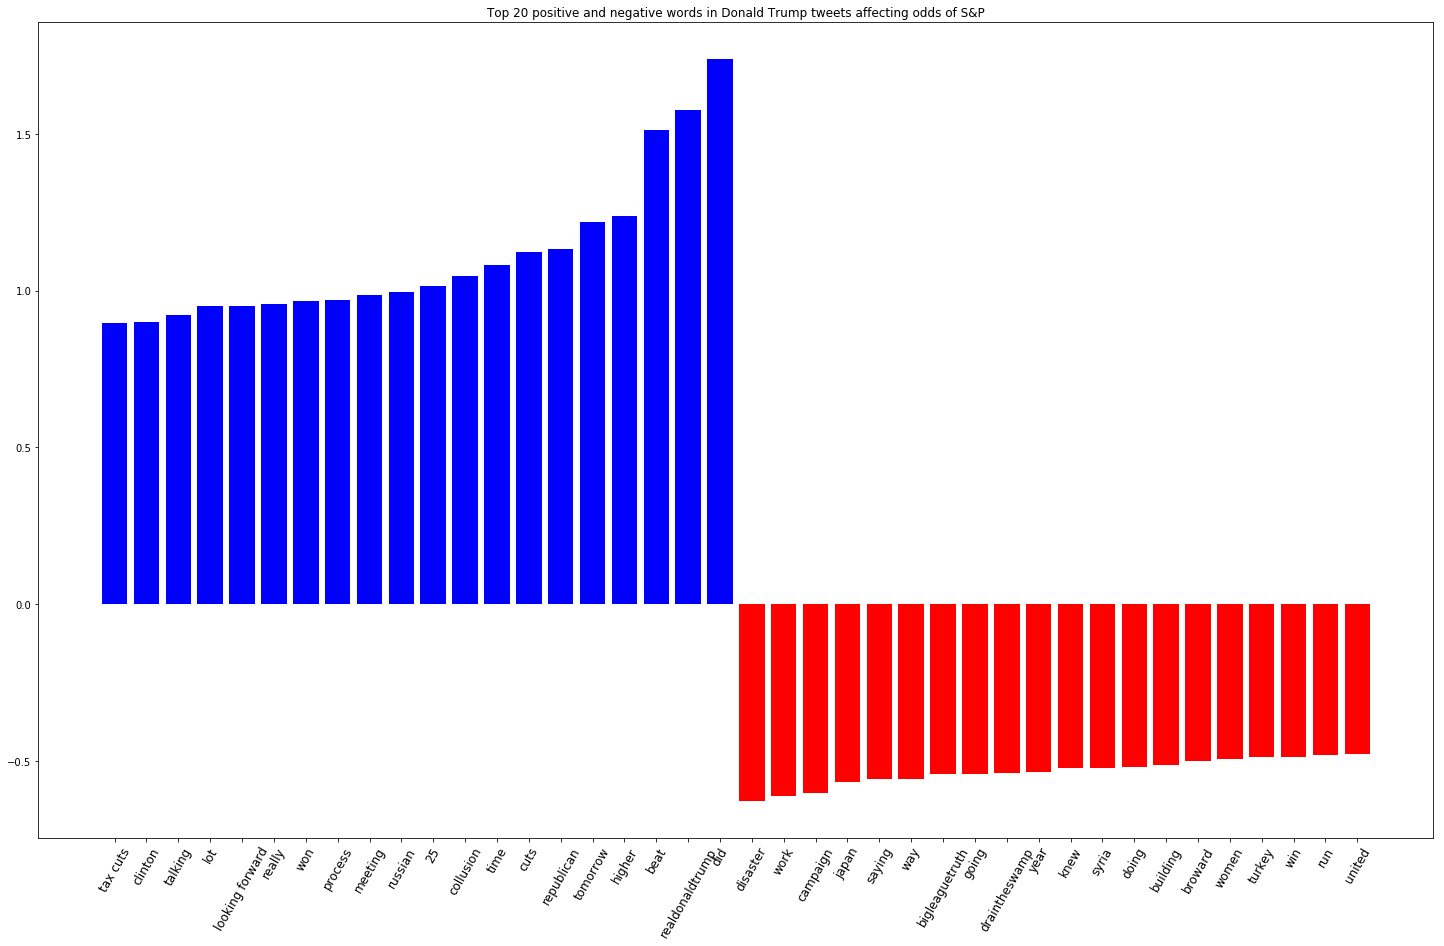

In [212]:
plt.figure(figsize=(25,15))
plt.bar(y_pos, probs_logs_odds, color=('blue','blue','blue','blue','blue','blue','blue','blue','blue','blue','blue','blue','blue','blue','blue','blue','blue','blue','blue','blue','red','red','red','red','red','red','red','red','red','red','red','red','red','red','red','red','red','red','red','red'))
plt.xticks(y_pos, coefs, rotation=60, size=12)
plt.title('Top 20 positive and negative words in Donald Trump tweets affecting odds of S&P')
plt.show()

After the careful analysis we saw how it is possible to construct deep learning algorithm that would be able to predict better than a mere random choice, which is already success considering the volatile nature of financial indicators, and especially stock prices. It is important to note that there are numerous indicators that potentially affect S&P 500 index price changes. There are numerous research articles directed at finding those indicators, among which I can note a famous paper by Harris and Gurel (1986). 

There are many analyses concluding that information flow is one of the main determinants of the stock price movements, however, noises also might affect its movements. Besides noted indicators, there are other basic macroeconomic variables that do affect stock prices, such as whether the economy is in a boom or depression (or recession), the exchange price movements, the inflation within the country, etc. In the models I generate I focused only on the news side of the effects, and even the news was selective and only coming from one person, Donald Trump. The consideration of tweets themselves as news can be argued, as I cannot be sure whether it is the noise after news declaration or the news itself. These all arguments already indicate that a precise and outstanding result is practically impossible. However, even with these limitations there are interesting insights into the analysis. 

If we zoom the last figure, it can be seen that most positive words are 'did', 'realdonaldtrump','higher', 'beat', 'won', 'looking forward', 'cuts', 'tax cuts', etc. There words represent the attitude of Trump for instance if he 'did' something it is considered to be positive for economy, which is logical if we think about him as a person with business background. Then 'won’, 'looking forward', 'higher' imply good future results which influence positively or 'tax cuts' rightfully is recognized as positive for S&P 500 index price increase. 

Interestingly enough, the model also recognized 'russian' as positive word for S&P 500 index price increase, which once again indicates on the controversy around his presidency. 


On the other hand, 'disaster', 'work', 'campaign', 'japan','draintheswamp','turkey', etc. have a negative impact on S&P 500 index price change. Thus, we can say that these word contain some negativity and it impacts S&P 500 index price change leading it to decrease. 

Given the limitations of the data, the deep learning algorithm revealed insightful conclusion from the results. The further evident improvement for the model would be consideration of different indicators. 